In [1]:
import sys
sys.path.append('..')

from uncertain.explicit import MF, CPMF, OrdRec
from utils.data import MovieLens
from utils.training import train
from utils.evaluation import test_ratings, test_recommendations, uncertainty_distributions

ML = MovieLens(batch_size=512)
ML.prepare_data()

results = {'MF': {}, 'CPMF': {}, 'OrdRec': {}}

MovieLens data prepared: 6040 users, 3706 item.
951889 Train interactions, 24160 validation and test interactions.


# ExplicitMF (FunkSVD)

In [2]:
model = MF(ML.n_user, ML.n_item, embedding_dim=10, lr=1e-3, weight_decay=0.00001)
train(model, ML)
results['MF'].update(test_ratings(model, ML))
results['MF'].update(test_recommendations(model, ML, max_k=10))
results['MF']

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

{'RMSE': 0.9308839772792418,
 'Precision': array([0.01788079, 0.01738411, 0.01616998, 0.01548013, 0.01476821,
        0.01415563, 0.01381268, 0.01351407, 0.01326343, 0.01294702]),
 'Recall': array([0.0044702 , 0.00869205, 0.01212748, 0.01548013, 0.01846026,
        0.02123344, 0.02417219, 0.02702815, 0.02984272, 0.03236755]),
 'NDCG': array([0.01788079, 0.04444057, 0.06741077, 0.09001991, 0.109424  ,
        0.12746698, 0.14539482, 0.16192532, 0.17769222, 0.19286925]),
 'Diversity': array([0.05246796, 0.05447598, 0.05591262, 0.0569327 , 0.05776382,
        0.05849383, 0.05902373, 0.05949817, 0.0599628 ]),
 'Novelty': array([0.25304989, 0.25734139, 0.25751549, 0.25817388, 0.25810783,
        0.25920677, 0.25948076, 0.25878553, 0.25832881, 0.2590046 ])}

# CPMF

In [3]:
model = CPMF(ML.n_user, ML.n_item, embedding_dim=10, lr=1e-3, weight_decay=0.00001)
train(model, ML)
results['CPMF'].update(test_ratings(model, ML))
results['CPMF'].update(test_recommendations(model, ML, max_k=10))
results['CPMF']

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | user_gammas     | Embedding | 6.0 K 
3 | item_gammas     | Embedding | 3.7 K 
4 | var_activation  | Softplus  | 0     
----------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.429     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

{'RMSE': 0.9278848994162279,
 'RPI': 0.6250399240676823,
 'Classification': 0.6165725220402198,
 'Quantile RMSE': array([0.6370149 , 0.71889116, 0.75422004, 0.79204049, 0.8392283 ,
        0.82661296, 0.85918687, 0.89761052, 0.89267037, 0.89407963,
        0.9082971 , 1.00230669, 1.01506698, 0.9569057 , 0.99293121,
        1.01741305, 1.01752678, 1.11777334, 1.09925752, 1.13319239]),
 'Precision': array([0.0205298 , 0.01812914, 0.01628035, 0.01568709, 0.01483444,
        0.01421082, 0.01359981, 0.01343129, 0.01300589, 0.01263245]),
 'Recall': array([0.00513245, 0.00906457, 0.01221026, 0.01568709, 0.01854305,
        0.02131623, 0.02379967, 0.02686258, 0.02926325, 0.03158113]),
 'NDCG': array([0.0205298 , 0.0472178 , 0.06874594, 0.09153335, 0.11094301,
        0.12938953, 0.14544617, 0.16175942, 0.17496131, 0.18981269]),
 'Diversity': array([0.04084447, 0.04299191, 0.04456607, 0.04595929, 0.04696424,
        0.04779769, 0.0484334 , 0.04902692, 0.04959313]),
 'Novelty': array([0.23951898

# OrdRec

In [4]:
ML.to_ordinal()
model = OrdRec(ML.n_user, ML.n_item, ML.score_labels, embedding_dim=10, lr=1e-3, weight_decay=0.000005)
train(model, ML)
results['OrdRec'].update(test_ratings(model, ML))
results['OrdRec'].update(test_recommendations(model, ML, max_k=10))
results['OrdRec']

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | user_betas      | Embedding | 24.2 K
----------------------------------------------
121 K     Trainable params
0         Non-trainable params
121 K     Total params
0.486     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

{'RMSE': 0.931636093920223,
 'RPI': 0.7640762034840399,
 'Classification': 0.6685894667459045,
 'Quantile RMSE': array([0.65166252, 0.67337247, 0.71654457, 0.7418241 , 0.75138823,
        0.81106287, 0.8510586 , 0.83405938, 0.86112595, 0.89850231,
        0.91654233, 0.93263781, 0.94273264, 0.98842458, 1.01115513,
        1.03263099, 1.08497226, 1.11156216, 1.19593196, 1.31015192]),
 'Precision': array([0.02036424, 0.01846026, 0.01721854, 0.01705298, 0.01655629,
        0.01614238, 0.01558657, 0.01504553, 0.01482708, 0.01432119]),
 'Recall': array([0.00509106, 0.00923013, 0.01291391, 0.01705298, 0.02069536,
        0.02421358, 0.02727649, 0.03009106, 0.03336093, 0.03580298]),
 'NDCG': array([0.02036424, 0.04673356, 0.07169404, 0.09631834, 0.11948088,
        0.14071147, 0.15868293, 0.1761168 , 0.19267061, 0.20679635]),
 'Diversity': array([0.13014185, 0.13618422, 0.13950016, 0.14188781, 0.14326799,
        0.14442994, 0.14520248, 0.14564462, 0.14598093]),
 'Novelty': array([0.55380562,

# Results

            RMSE       RPI  Classification
MF      0.930884       NaN             NaN
CPMF    0.927885  0.625040        0.616573
OrdRec  0.931636  0.764076        0.668589


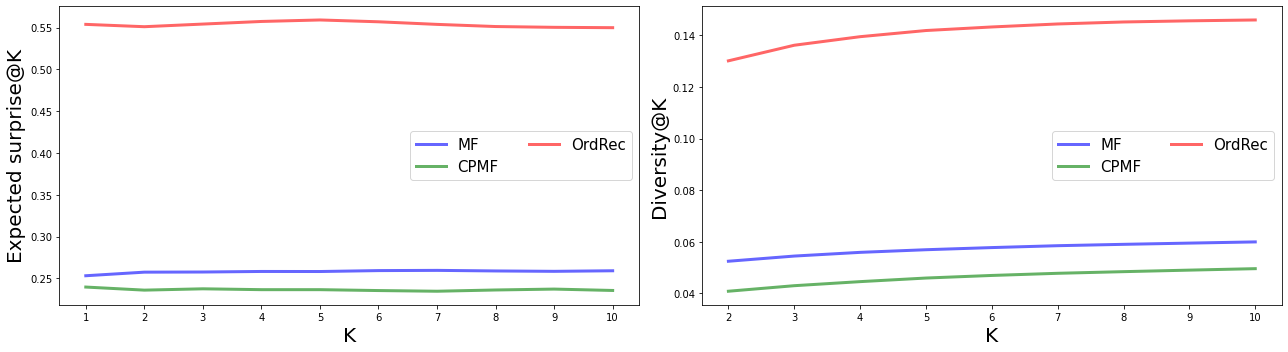

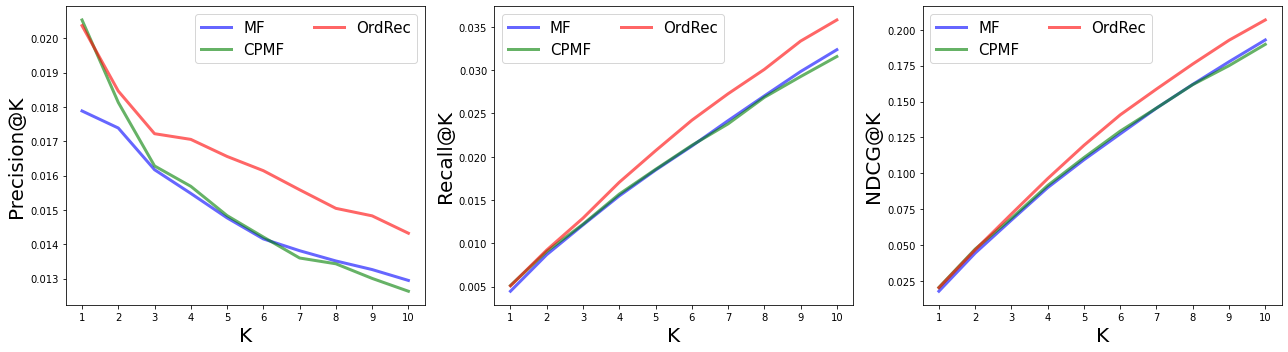

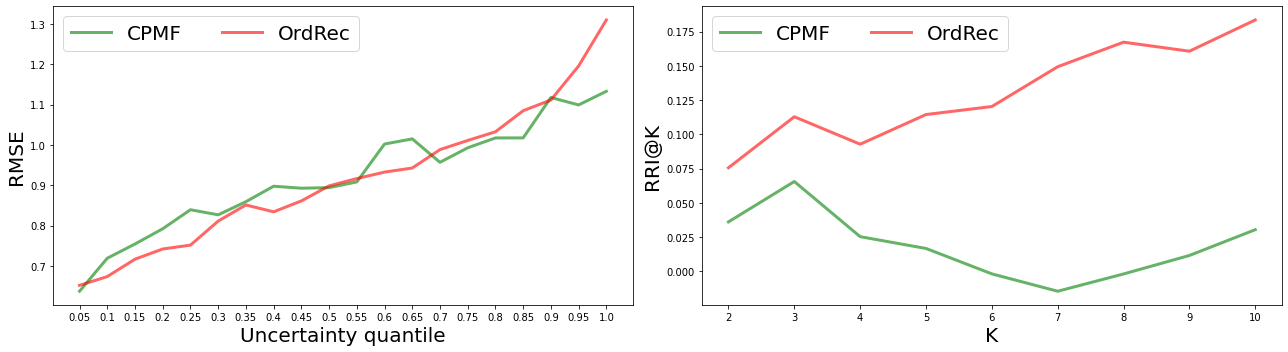

In [31]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import BASE_COLORS
colors = [c for c in list(BASE_COLORS)]
keys = results_df.index.to_list()
colors = {keys[i]:colors[i] for i in range(len(keys))}

results_df = pd.DataFrame.from_dict(results, orient='Index')
ratings = results_df[['RMSE', 'RPI', 'Classification']]
print(ratings)

f, ax = plt.subplots(ncols=2, figsize=(18, 5))
for key in keys:
    ax[0].plot(np.arange(1, 11), results_df['Novelty'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(2, 11), results_df['Diversity'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('K', fontsize=20)
ax[0].set_ylabel('Expected surprise@K', fontsize=20)
ax[0].legend(ncol=2, fontsize=15)
ax[1].set_xticks(np.arange(2, 11))
ax[1].set_xlabel('K', fontsize=20)
ax[1].set_ylabel('Diversity@K', fontsize=20)
ax[1].legend(ncol=2, fontsize=15)
f.tight_layout()

f, ax = plt.subplots(ncols=3, figsize=(18, 5), sharex=True)
for key in keys:
    ax[0].plot(np.arange(1, 11), results_df['Precision'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 11), results_df['Recall'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[2].plot(np.arange(1, 11), results_df['NDCG'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('K', fontsize=20)
ax[0].set_ylabel('Precision@K', fontsize=20)
ax[0].legend(ncol=2, fontsize=15)
ax[1].set_xlabel('K', fontsize=20)
ax[1].set_ylabel('Recall@K', fontsize=20)
ax[1].legend(ncol=2, fontsize=15)
ax[2].set_xlabel('K', fontsize=20)
ax[2].set_ylabel('NDCG@K', fontsize=20)
ax[2].legend(ncol=2, fontsize=15)
f.tight_layout()

f, ax = plt.subplots(ncols=2, figsize=(18, 5))
keys = ['CPMF', 'OrdRec']
for key in keys:
    ax[0].plot(np.arange(1, 21), results_df['Quantile RMSE'][key],
            '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(2, 11), results_df['RRI'][key],
            '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 21))
ax[0].set_xticklabels([round(elem, 2) for elem in np.linspace(start=0.05, stop=1, num=20).tolist()])
ax[0].set_xlabel('Uncertainty quantile', fontsize=20)
ax[0].set_ylabel('RMSE', fontsize=20)
ax[0].legend(ncol=2, fontsize=20)
ax[1].set_xlabel('K', fontsize=20)
ax[1].set_ylabel('RRI@K', fontsize=20)
ax[1].legend(ncol=2, fontsize=20)
f.tight_layout()